In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Download and load the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Plot two train examples and their corresponding labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

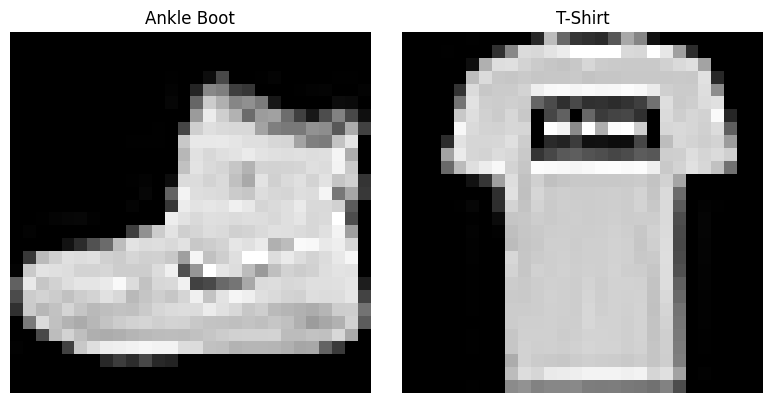

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    img, label = train_data[i]
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].set_title(labels_map[label])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Split the data into train and test loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

model = Net()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model.to(device)

# Train the network
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target to the device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Calculate train loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    
    # Evaluate on test data
    model.eval()
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            # Move data and target to the device
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * test_correct / len(test_loader.dataset)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Using device: cuda
Epoch [1/30], Train Loss: 0.0836, Train Accuracy: 96.89%, Test Loss: 0.2957, Test Accuracy: 92.99%
Epoch [2/30], Train Loss: 0.0800, Train Accuracy: 96.97%, Test Loss: 0.3091, Test Accuracy: 92.87%
Epoch [3/30], Train Loss: 0.0781, Train Accuracy: 97.10%, Test Loss: 0.2976, Test Accuracy: 92.87%
Epoch [4/30], Train Loss: 0.0799, Train Accuracy: 97.10%, Test Loss: 0.3014, Test Accuracy: 92.49%
Epoch [5/30], Train Loss: 0.0770, Train Accuracy: 97.08%, Test Loss: 0.3308, Test Accuracy: 92.72%
Epoch [6/30], Train Loss: 0.0752, Train Accuracy: 97.16%, Test Loss: 0.3261, Test Accuracy: 92.79%
Epoch [7/30], Train Loss: 0.0783, Train Accuracy: 97.00%, Test Loss: 0.3228, Test Accuracy: 92.71%


KeyboardInterrupt: 

/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


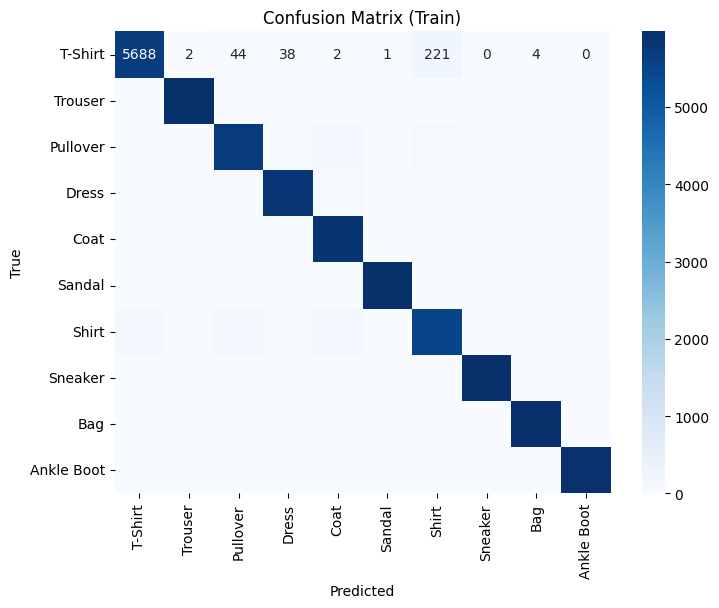

/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


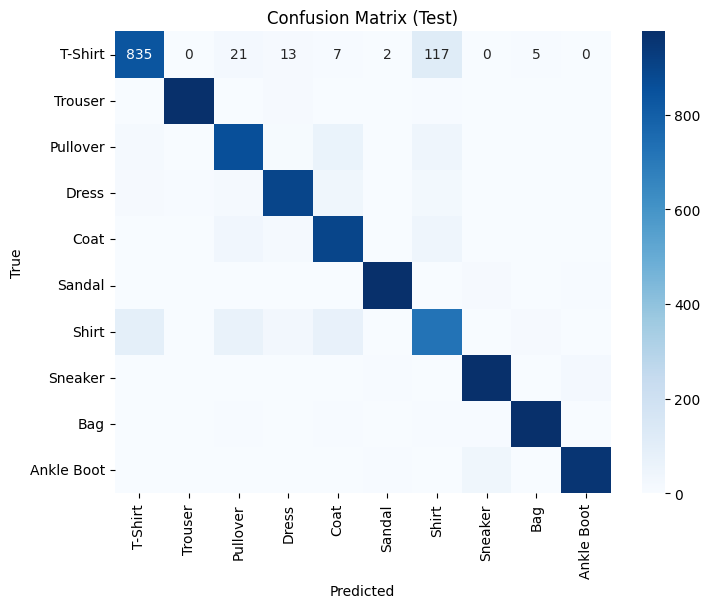

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(data_loader, title):
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(train_loader, 'Confusion Matrix (Train)')
plot_confusion_matrix(test_loader, 'Confusion Matrix (Test)')

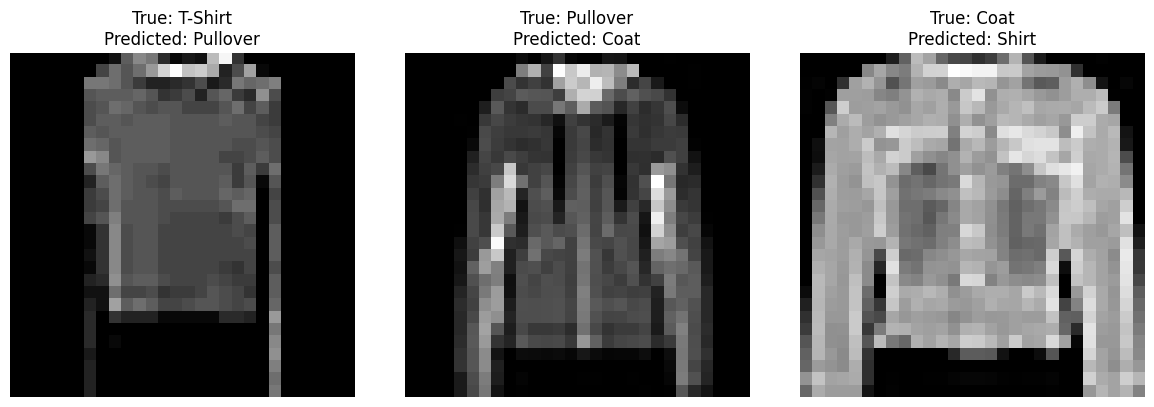

In [14]:
import random
def plot_incorrect_predictions(data_loader):
    incorrect_samples = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            incorrect_mask = pred != target
            incorrect_samples.extend(zip(data[incorrect_mask].cpu(), target[incorrect_mask].cpu(), pred[incorrect_mask].cpu()))
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    for i, (image, true_label, pred_label) in enumerate(random.sample(incorrect_samples, 3)):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'True: {labels_map[true_label.item()]}\nPredicted: {labels_map[pred_label.item()]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_incorrect_predictions(test_loader)

In [16]:
def calculate_accuracy(data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    accuracy = 100. * correct / total
    return accuracy

train_accuracy = calculate_accuracy(train_loader)
test_accuracy = calculate_accuracy(test_loader)

print(f'Train Accuracy: {train_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

Train Accuracy: 99.63%
Test Accuracy: 92.69%
